<a href="https://colab.research.google.com/github/duypham01/SAR_DRN/blob/master/Build_SAR_DRN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import os
import cv2
#import scipy
import matplotlib.pyplot as plt
import math

from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, Input, Dense, Add, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing import image
from scipy import ndimage
import tensorflow as tf
import keras as keras
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
from keras.losses import MeanSquaredError

In [23]:
X=[]
# for file_name in os.listdir("./drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images"):
#   for file_name_image in os.listdir("./drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images/" + file_name):
#     img = image.load_img("./drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images/" + file_name +"/"+ file_name_image, grayscale=True)
#     img = image.img_to_array(img)
#     img = cv2.resize(img, (256, 256))
#     img = img/255
#     img= np.round(img, 2)
#     X.append(img)

for file_name in os.listdir("./drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images/buildings"):
  img = image.load_img("./drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images/buildings/" + file_name, grayscale=True)
  img = np.asarray(img)
  img = cv2.resize(img, (256, 256))
  img = img.astype('float32')
  img = img/255.0
  X.append(img)
#X = np.array(X, dtype=float)
print(X)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


[array([[0.8627451 , 0.8627451 , 0.8627451 , ..., 0.37254903, 0.3764706 ,
        0.3764706 ],
       [0.89411765, 0.8784314 , 0.8509804 , ..., 0.3882353 , 0.3882353 ,
        0.38039216],
       [0.85882354, 0.81960785, 0.76862746, ..., 0.4       , 0.4117647 ,
        0.4117647 ],
       ...,
       [0.7137255 , 0.7137255 , 0.7294118 , ..., 0.24705882, 0.2627451 ,
        0.27058825],
       [0.7372549 , 0.7411765 , 0.7529412 , ..., 0.28235295, 0.28627452,
        0.3254902 ],
       [0.77254903, 0.75686276, 0.7607843 , ..., 0.34117648, 0.34117648,
        0.39215687]], dtype=float32), array([[0.3529412 , 0.2784314 , 0.25882354, ..., 0.56078434, 0.5921569 ,
        0.63529414],
       [0.2784314 , 0.24313726, 0.23137255, ..., 0.53333336, 0.54509807,
        0.57254905],
       [0.21176471, 0.22745098, 0.21568628, ..., 0.5882353 , 0.5764706 ,
        0.58431375],
       ...,
       [0.2784314 , 0.27450982, 0.25490198, ..., 0.45490196, 0.4509804 ,
        0.43529412],
       [0.29411766

In [26]:
X = np.array(X)
print(X.shape)
print(X)

(100, 256, 256)
[[[0.8627451  0.8627451  0.8627451  ... 0.37254903 0.3764706  0.3764706 ]
  [0.89411765 0.8784314  0.8509804  ... 0.3882353  0.3882353  0.38039216]
  [0.85882354 0.81960785 0.76862746 ... 0.4        0.4117647  0.4117647 ]
  ...
  [0.7137255  0.7137255  0.7294118  ... 0.24705882 0.2627451  0.27058825]
  [0.7372549  0.7411765  0.7529412  ... 0.28235295 0.28627452 0.3254902 ]
  [0.77254903 0.75686276 0.7607843  ... 0.34117648 0.34117648 0.39215687]]

 [[0.3529412  0.2784314  0.25882354 ... 0.56078434 0.5921569  0.63529414]
  [0.2784314  0.24313726 0.23137255 ... 0.53333336 0.54509807 0.57254905]
  [0.21176471 0.22745098 0.21568628 ... 0.5882353  0.5764706  0.58431375]
  ...
  [0.2784314  0.27450982 0.25490198 ... 0.45490196 0.4509804  0.43529412]
  [0.29411766 0.28235295 0.2509804  ... 0.43137255 0.45490196 0.44705883]
  [0.2627451  0.26666668 0.24705882 ... 0.41568628 0.43529412 0.43137255]]

 [[0.43529412 0.41568628 0.44313726 ... 0.5686275  0.59607846 0.5372549 ]
  [0.3

In [27]:
print(X.shape)
X = X[:80,]
X_train = X[:70,]
X_test = X[70:,]
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)
print(X_train.shape)

(100, 256, 256)
(70, 256, 256, 1)


In [0]:
def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck

In [0]:
def reImg(img):
    img_new = img
    img_new[img_new > 1] = 1
    img_new[img_new <= 0] = 0
    return img_new

In [30]:
Y=[]
for x in X:
  y = speckle(x)
  Y.append(y)
Y = np.array(Y, dtype=float)
print(Y.shape)
print(Y)

(80, 256, 256)
[[[0.8091051  0.89286392 0.96982562 ... 0.37727987 0.21910375 0.20382489]
  [0.9055842  0.96472712 0.954381   ... 0.38112313 0.25915221 0.21840374]
  [0.84886256 0.88530395 0.81160836 ... 0.36794028 0.33901255 0.33565349]
  ...
  [0.72505897 0.70963535 0.82471431 ... 0.2113524  0.13056117 0.15783347]
  [0.81393105 0.79014456 0.85419979 ... 0.19985374 0.10920982 0.16035852]
  [0.98223712 0.91772205 0.90219541 ... 0.24503812 0.16105118 0.18069092]]

 [[0.03206237 0.         0.         ... 0.44888713 0.56041553 0.69994953]
  [0.05892351 0.02126669 0.01682726 ... 0.51505657 0.61392141 0.70549037]
  [0.11145449 0.22560455 0.25195134 ... 0.65874199 0.68202909 0.6519758 ]
  ...
  [0.16848502 0.26926496 0.34945788 ... 0.4828892  0.52703741 0.45790482]
  [0.17230507 0.25213606 0.34549351 ... 0.58842574 0.57921336 0.49739718]
  [0.17716119 0.31845027 0.4189755  ... 0.68956604 0.74623501 0.74503775]]

 [[0.05576256 0.14273181 0.46228362 ... 0.51212241 0.47785269 0.37239515]
  [0.  

In [31]:
X_train_noise = Y[:70,]
X_test_noise = Y[70:,]
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 256, 256, 1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], 256, 256, 1)
print(X_train_noise.shape)
print(X_test_noise.shape)

(70, 256, 256, 1)
(10, 256, 256, 1)


In [32]:
X_res = X_train_noise - X_train
X_res_test = X_test_noise - X_test
print(X_res.shape)
print(X_res[0])
print(X_res_test.shape)

(70, 256, 256, 1)
[[[-0.05364   ]
  [ 0.03011881]
  [ 0.10708052]
  ...
  [ 0.00473085]
  [-0.15736684]
  [-0.1726457 ]]

 [[ 0.01146655]
  [ 0.08629574]
  [ 0.1034006 ]
  ...
  [-0.00711217]
  [-0.12908309]
  [-0.16198843]]

 [[-0.00996097]
  [ 0.0656961 ]
  [ 0.0429809 ]
  ...
  [-0.03205972]
  [-0.07275216]
  [-0.07611122]]

 ...

 [[ 0.01133346]
  [-0.00409016]
  [ 0.09530252]
  ...
  [-0.03570642]
  [-0.13218394]
  [-0.11275478]]

 [[ 0.07667614]
  [ 0.04896807]
  [ 0.1012586 ]
  ...
  [-0.08249921]
  [-0.1770647 ]
  [-0.16513169]]

 [[ 0.20968809]
  [ 0.16085929]
  [ 0.14141108]
  ...
  [-0.09613836]
  [-0.1801253 ]
  [-0.21146595]]]
(10, 256, 256, 1)


In [0]:
input_tensor = Input((256,256,1))
L1 = Conv2D(64, (3, 3), dilation_rate=(1, 1), activation='relu', strides=(1, 1), padding='same')(input_tensor)
L2 = Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', strides=(1, 1), padding='same')(L1)
L3 = Conv2D(64, (3, 3), dilation_rate=(3, 3), activation='relu', strides=(1, 1), padding='same')(L2)
addedL1L3 = Add()([L1, L3])
L4 = Conv2D(64, (3, 3), dilation_rate=(4, 4), activation='relu', strides=(1, 1), padding='same')(addedL1L3)
L5 = Conv2D(64, (3, 3), dilation_rate=(3, 3), activation='relu', strides=(1, 1), padding='same')(L4)
L6 = Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', strides=(1, 1), padding='same')(L5)
addedL4L6 = Add()([L4, L6])
L7 = Conv2D(1, (3, 3), dilation_rate=(1, 1), strides=(1, 1), padding='same')(addedL4L6)
#FinalL = Lambda(lambda inputs: inputs[0] - inputs[1])([input_tensor, L7])
model = Model(inputs=input_tensor, outputs=L7)
optimizer = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# def mse(imageA, imageB):
#   # the 'Mean Squared Error' between the two images is the
#   # sum of the squared difference between the two images;
#   # NOTE: the two images must have the same dimension
#   err = np.sum((imageA[0] - imageB[0]) ** 2)
#   err /= float(256.0*256.0)
	
# 	# return the MSE, the lower the error, the more "similar"
# 	# the two images are
#   return err
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error'
)


In [34]:
H = model.fit(X_train_noise, X_res, validation_data=(X_test_noise, X_res_test),
          batch_size=32, epochs=10, verbose=1)

Train on 70 samples, validate on 10 samples
Epoch 1/10
70/70 [==============================] - 140s 2s/step - loss: 0.0252 - val_loss: 0.0106
Epoch 2/10
70/70 [==============================] - 129s 2s/step - loss: 0.0115 - val_loss: 0.0116
Epoch 3/10
70/70 [==============================] - 131s 2s/step - loss: 0.0095 - val_loss: 0.0102
Epoch 4/10
70/70 [==============================] - 131s 2s/step - loss: 0.0088 - val_loss: 0.0094
Epoch 5/10
70/70 [==============================] - 131s 2s/step - loss: 0.0080 - val_loss: 0.0090
Epoch 6/10
70/70 [==============================] - 136s 2s/step - loss: 0.0077 - val_loss: 0.0084
Epoch 7/10
70/70 [==============================] - 131s 2s/step - loss: 0.0072 - val_loss: 0.0079
Epoch 8/10
70/70 [==============================] - 129s 2s/step - loss: 0.0068 - val_loss: 0.0073
Epoch 9/10
70/70 [==============================] - 131s 2s/step - loss: 0.0064 - val_loss: 0.0068
Epoch 10/10
70/70 [==============================] - 132s 2s/step

(256, 256)
[[119 121 126 ... 128 125 124]
 [118 122 128 ... 127 125 131]
 [119 124 129 ... 127 126 134]
 ...
 [106 104  99 ... 152 150 144]
 [118 117 116 ... 151 151 147]
 [ 89  81  87 ... 146 147 150]]


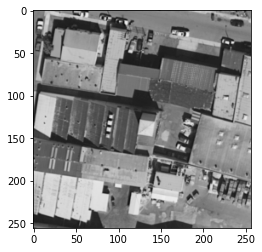

In [35]:
img = image.load_img("./drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images/buildings/buildings88.tif", color_mode="grayscale")
img = np.asarray(img)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
print(img.shape)
print(img)
plt.show()

In [36]:
img = cv2.resize(img, (256, 256))
#img = np.asarray(img)
img = img.astype('float32')
img = img/255.0

print(img.shape)
print(img)

(256, 256)
[[0.46666667 0.4745098  0.49411765 ... 0.5019608  0.49019608 0.4862745 ]
 [0.4627451  0.47843137 0.5019608  ... 0.49803922 0.49019608 0.5137255 ]
 [0.46666667 0.4862745  0.5058824  ... 0.49803922 0.49411765 0.5254902 ]
 ...
 [0.41568628 0.40784314 0.3882353  ... 0.59607846 0.5882353  0.5647059 ]
 [0.4627451  0.45882353 0.45490196 ... 0.5921569  0.5921569  0.5764706 ]
 [0.34901962 0.31764707 0.34117648 ... 0.57254905 0.5764706  0.5882353 ]]


In [37]:
img_noise = speckle(img)
print(img_noise)

[[0.58626664 0.43203205 0.46569443 ... 0.79608492 0.58946602 0.23795911]
 [0.43857476 0.49755568 0.60142191 ... 0.53503614 0.39439357 0.28005469]
 [0.54300666 0.6836097  0.78784722 ... 0.38573409 0.34058848 0.30469564]
 ...
 [0.42791453 0.37763039 0.32849429 ... 0.40932608 0.58777136 0.69013601]
 [0.57283766 0.52529268 0.43519496 ... 0.63149387 0.72993129 0.78755611]
 [0.51339388 0.34960172 0.16947628 ... 0.76314541 0.79502533 0.86295985]]


[[149 110 118 ... 203 150  60]
 [111 126 153 ... 136 100  71]
 [138 174 200 ...  98  86  77]
 ...
 [109  96  83 ... 104 149 175]
 [146 133 110 ... 161 186 200]
 [130  89  43 ... 194 202 220]]


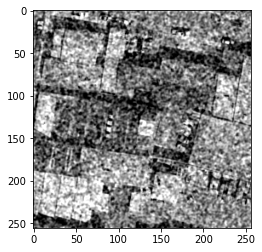

In [38]:
img_noise_256 = img_noise*255.0
img_noise_256 = img_noise_256.astype('int32')
print(img_noise_256)
plt.imshow(img_noise_256, cmap='gray', vmin=0, vmax=255)
plt.show()

In [39]:
img_noise_pred = img_noise.reshape(1,256, 256, 1)
print(img_noise_pred.shape)

(1, 256, 256, 1)


In [40]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [41]:
pred = model.predict(img_noise_pred)
print(pred.shape)

(1, 256, 256, 1)


In [42]:
pred = pred.reshape(256,256)
print(pred.shape)
pred_img = img - pred
pred_img = reImg(pred_img)
print(pred_img.shape)

(256, 256)
(256, 256)


In [43]:
print(pred_img)

[[0.46133304 0.46989152 0.49991417 ... 0.4248647  0.42012143 0.4776566 ]
 [0.4366805  0.43675086 0.46730557 ... 0.42859802 0.42746645 0.5294974 ]
 [0.41500127 0.3810159  0.390316   ... 0.47242394 0.4661136  0.5543214 ]
 ...
 [0.37553477 0.3898221  0.37966046 ... 0.58704615 0.5245501  0.560925  ]
 [0.41264158 0.4110209  0.42902654 ... 0.53609806 0.49353993 0.5620994 ]
 [0.32729065 0.2942898  0.34406263 ... 0.53714836 0.5156943  0.55165523]]


[[117 119 127 ... 108 107 121]
 [111 111 119 ... 109 109 135]
 [105  97  99 ... 120 118 141]
 ...
 [ 95  99  96 ... 149 133 143]
 [105 104 109 ... 136 125 143]
 [ 83  75  87 ... 136 131 140]]


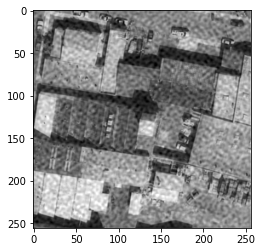

In [44]:
pred_256 = pred_img*255.0
pred_256 = pred_256.astype('int32')
print(pred_256)
plt.imshow(pred_256, cmap='gray', vmin=0, vmax=255)
plt.show()

In [46]:
mse = MeanSquaredError()
errPSNRImg_img_noise = psnr(img, img_noise)
errPSNRImg_img_pred = psnr(img, pred_img)
errSSIMImg_img_noise = ssim(img, img_noise)
errSSIMImg_img_pred = ssim(img, pred_img)
errMSEImg_img_noise = mse(img, img_noise)
errMSEImg_img_pred = mse(img, pred_img)
print(errPSNRImg_img_noise)
print(errPSNRImg_img_pred)
print(errSSIMImg_img_noise)
print(errSSIMImg_img_pred)
print(errMSEImg_img_noise.numpy())
print(errMSEImg_img_pred.numpy())

16.39564388379037
23.844950427219302
0.4398233573358169
0.7338130932218864
0.022931665
0.0041257697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.6/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure 

In [11]:
from keras.models import load_model
model = load_model("./drive/My Drive/Colab Notebooks/SAR_DRN.h5")
print(model.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 256, 256, 64) 640         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_65[0][0]                  
___________________________________________________________________________________________